In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
from DEDi import ode_find as ode
from DEDi.ODE.PolyLib import PolyFunc
import numpy as np
import matplotlib.pyplot as plt

### Van Der Pol Oscillator
$\mu = 2$

\begin{align}
    \frac{dx}{dt} &= y \\
    \frac{dy}{dt} &= \mu(1-x^2)y - x
\end{align}

Size = (250, 2), dt = 0.04


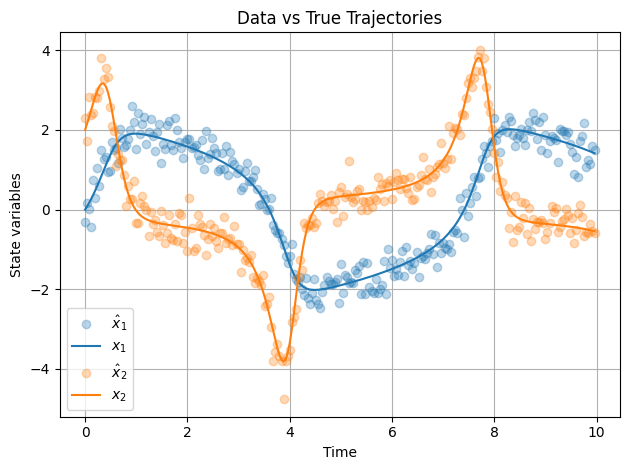

In [2]:
Data = np.load('../_ODEData/VDPData.npz')
x_data_true_full = Data['x']
t_full = Data['t']

np.random.seed(123)
subsample = 40
x_data_true = x_data_true_full[::subsample]
t = t_full[::subsample]


noise_p, stand_dev = .2, np.std(x_data_true, axis = 0)
x_data = x_data_true + np.random.normal(0,stand_dev*noise_p, size = x_data_true.shape)

# Define validation mask, standard is every third time (33% of data)
validation_mask = np.ones_like(x_data, dtype=bool)
validation_mask[2::3] = False

print(f'Size = {np.shape(x_data)}, dt = {t[1]-t[0]}')
from DEDi.plot_trajectories import plot_trajectory
plot_trajectory(t,x_data,x_data_true)

In [3]:
Library = PolyFunc(num_vars=x_data.shape[1],degree=2) #VDP has a degree 3 term, see what happens when not included
print(Library)

# Initialize Library & Model Discovery
lambdas,Rs  = 10**(np.linspace(-3, 3, 7)),10**(np.linspace(-4, 0, 5))  #Parameter's used in paper, better to try a simple run first 
# lambdas = [10**(-2)]
# Rs = [10**(-4)]

discoverode = ode(x_data,Library,[t[0],t[-1]], validation_mask=validation_mask)
discoverode.FindBestModel(lambdas, Rs)

['x_1', 'x_2', 'x_1**2', 'x_1*x_2', 'x_2**2']
Setting up Sparse Hessian
Colors Needed = 17
lam = 1.00e-03, R = 1.00e-04, nonzero = 5, val_error = 5.0333e-01,BIC = -8.8402e+01, model_error = 1.2192e-07, state_error = 4.6218e-01
lam = 1.00e-03, R = 1.00e-03, nonzero = 5, val_error = 5.0340e-01,BIC = -8.8378e+01, model_error = 1.2187e-07, state_error = 4.6219e-01
lam = 1.00e-03, R = 1.00e-02, nonzero = 5, val_error = 5.0337e-01,BIC = -8.8387e+01, model_error = 1.1982e-07, state_error = 4.6216e-01
[Failed to Converged] Iter 500: ||grad|| = 4.09e-01
[Failed to Converged] Iter 500: ||grad|| = 2.14e-01
lam = 1.00e-03, R = 1.00e-01, nonzero = 2, val_error = 5.2427e-01,BIC = -9.6971e+01, model_error = 1.0365e-07, state_error = 4.8007e-01
[Failed to Converged] Iter 500: ||grad|| = 5.12e-03
[Failed to Converged] Iter 500: ||grad|| = 4.05e-02
lam = 1.00e-03, R = 1.00e+00, nonzero = 2, val_error = 5.2426e-01,BIC = -9.6973e+01, model_error = 1.0370e-07, state_error = 4.8007e-01
lam = 1.00e-02, R = 1

In [4]:
models = discoverode.PrintModels(N_best= 3) #Increase cutoff to see other models found, here we see many models are repetitive. Further down shows how to find the best unique structures

<IPython.core.display.Latex object>

In [5]:
opt_params, opt_NL_params, opt_states = discoverode.best_model()

from _ODEData.Functions.ODEFuncs import generate_coeff_matrix, getvdpcoeffs, Report_Errors
true_coeffs = generate_coeff_matrix(Library, getvdpcoeffs())
L2_error, LInf_error, true_positivity_ratio = Report_Errors(true_coeffs, opt_params)
print(f"L2 Error = {L2_error:.3e}, LInf Error = {LInf_error:.3e}, TPR = {int(true_positivity_ratio*100)}%")

L2 Error = 8.169e-01, LInf Error = 1.000e+00, TPR = 66%


In [6]:
#This function returns only the unique models, as many are duplicates. If duplicated, model with lowest validation gets returned. Since 

best_models_by_struct = discoverode.get_best_models_by_structure(discoverode.tested_models)
models = discoverode.PrintModels(N_best= 5, tested_models=best_models_by_struct, return_latex=True) #Increase cutoff to see other models found

<IPython.core.display.Latex object>

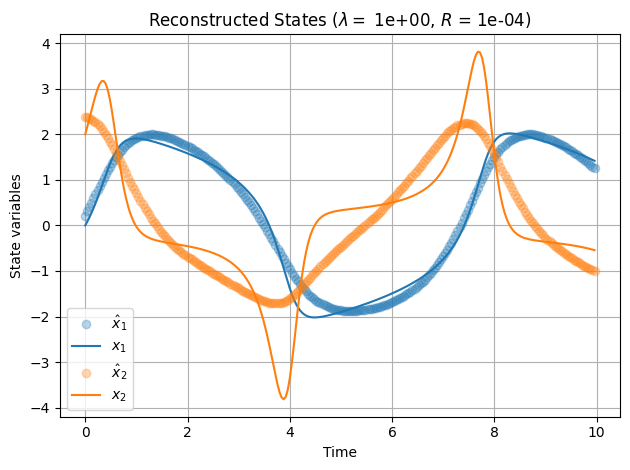

In [7]:
lam, r, BIC, validation_error, model_error, state_error, sparse_penalty, opt_states, opt_params, opt_NL_params = best_models_by_struct[1]
plot_trajectory(t,opt_states, x_data_true, title = f"Reconstructed States ($ \lambda =$ {lam:.0e}, $R$ = {r:.0e})")
# plt.savefig(f'Images/VDP_Insufficient_{lam}.pdf')